In [1]:
# Preliminaries to work with the data.   
%matplotlib inline
%run __init__.py
import matplotlib as mpl
from scipy.stats import ttest_rel
import utils
from utils import loading, scoring
from gerkin import dream,params#,fit2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Load and organize the features and descriptor data

In [2]:
# Load the data
descriptors = loading.get_descriptors(format=True)
sets = ['training','leaderboard']#,'testset'])
all_CIDs = loading.get_CIDs(sets)
all_CID_dilutions = loading.get_CID_dilutions(sets)
#features_full = dream.get_molecular_data(['dragon','episuite','morgan','nspdk','gramian'],all_CIDs)
features_drag_morg = loading.get_molecular_data(['dragon','morgan'],all_CIDs)
features_drag = loading.get_molecular_data(['dragon'],all_CIDs)

Dragon has 4869 features for 476 molecules.
Morgan has 2437 features for 407 molecules.
There are now 7306 total features.
Dragon has 4869 features for 476 molecules.
There are now 4869 total features.


In [40]:
# Create the feature and descriptor arrays
X_drag,_,_,_,_,_ = dream.make_X(features_drag,all_CID_dilutions)
X_drag_morg,_,_,_,_,_ = dream.make_X(features_drag_morg,all_CID_dilutions)
X_drag_sq = dream.quad_prep(features_drag,all_CID_dilutions)
X_drag_morg_sq = dream.quad_prep(features_drag_morg,all_CID_dilutions)
Y = loading.load_perceptual_data(sets)

The X matrix now has shape (745x3063) molecules by non-NaN good molecular descriptors
The X matrix now has shape (745x5497) molecules by non-NaN good molecular descriptors
The X matrix now has shape (2235x4871) molecules by non-NaN good molecular descriptors
The X matrix now has shape (2235x7308) molecules by non-NaN good molecular descriptors


In [43]:
X_drag.drop('mean_dilution',1,inplace=True)
X_drag_morg.drop('mean_dilution',1,inplace=True)
X_drag_sq.drop('mean_dilution',1,inplace=True)
X_drag_morg_sq.drop('mean_dilution',1,inplace=True)

In [53]:
Y_mean = Y['Subject'].mean(axis=1).unstack('Descriptor')

## Compute or load correlations for the linear model

### Load or compute feature ranks for the linear model

In [54]:
n_splits = 100
use_saved_linear_feature_ranks = True
if use_saved_linear_feature_ranks:
    lin_ranked_drag_morg = np.load('../../data/lin_ranked_rick.npy')
else:
    lin_ranked_drag_morg = fit2.compute_linear_feature_ranks_cv(X_drag_morg_sq,Y_mean,
                                                                n_resampling=10,n_splits=n_splits)
    np.save('../../data/lin_ranked_rick',lin_ranked_drag_morg)

In [55]:
use_saved_linear_feature_ranks = True
if use_saved_linear_feature_ranks:
    lin_ranked_drag = np.load('../../data/lin_ranked_rick_drag.npy')
else:
    lin_ranked_drag = fit2.compute_linear_feature_ranks_cv(X_drag_sq,Y__mean,
                                                                n_resampling=10,n_splits=n_splits)
    np.save('../../data/lin_ranked_rick_drag',lin_ranked_drag)

In [7]:
use_saved_linear_model = True
max_features = 1000
alpha = 10.0
if use_saved_linear_model:
    rs_lin_with_morgan = np.load('../../data/rs_lin_with_morgan.npy')
else:
    rs_lin_with_morgan = fit2.master_cv(X_drag_morg_sq,Y_mean,n_splits=n_splits,model='ridge',
                                        alpha=alpha,feature_list=lin_ranked_drag_morg[:,:,:max_features])
    np.save('../../data/rs_lin_with_morgan',rs_lin_with_morgan)

In [8]:
use_saved_linear_model = True
if use_saved_linear_model:
    rs_lin_without_morgan = np.load('../../data/rs_lin_without_morgan.npy')
else:
    rs_lin_without_morgan = fit2.master_cv(X_drag_sq,Y_mean,n_splits=n_splits,model='ridge',
                                        alpha=alpha,feature_list=lin_ranked_drag[:,:,:max_features])
    np.save('../../data/rs_lin_without_morgan',rs_lin_without_morgan)

## Compute or load correlations for the random forest model

In [56]:
use_saved_rf_model = True
if use_saved_rf_model:
    rs_dec_with_morgan = np.load('../../data/rs_dec_with_morgan.npy')
else:
    rs_dec_with_morgan = fit2.master_cv(X_drag_morg,Y,n_estimators=50,n_splits=n_splits,model='rf')
    np.save('../../data/rs_dec_with_morgan',rs_dec_with_morgan)

In [57]:
use_saved_rf_model = True
if use_saved_rf_model:
    rs_dec_without_morgan = np.load('../../data/rs_dec_without_morgan.npy')
else:
    rs_dec_without_morgan = fit2.master_cv(X_drag,Y,n_estimators=50,n_splits=n_splits,model='rf')
    np.save('../../data/rs_dec_without_morgan',rs_dec_without_morgan)

## Fig. 5A

In [58]:
n_splits = 50
# Compute differences between with and without Morgan.  
wit = [rs_dec_with_morgan[:,:n_splits],rs_lin_with_morgan[:,:n_splits]]
wout = [rs_dec_without_morgan[:,:n_splits],rs_lin_without_morgan[:,:n_splits]]
diff = [wit[i].mean(axis=1) - wout[i].mean(axis=1) for i in range(2)]
order = [np.argsort(diff[i])[::-1] for i in range(2)]
order[1] = order[0]
ts,ps = [np.zeros(21),np.zeros(21)],[np.zeros(21),np.zeros(21)]

# Compute p-values and sort by effect size
for i in range(2):
    for j in range(21):
        ts[i][j],ps[i][j] = ttest_rel(wit[i][j,:],wout[i][j,:])
        ps[i][j] = ps[i][j]*21/(np.argsort(ps[i][j])+1) # FDR correction
    ts[i] = ts[i][order[i]]
    ps[i] = ps[i][order[i]]
    diff[i] = diff[i][order[i]]
    wit[i] = wit[i][order[i],:]
    wout[i] = wout[i][order[i],:]   
    
# Compute error bars
yerr = [(wit[i] - wout[i]).std(axis=1)/np.sqrt(n_splits) for i in range(2)]
yerr1 = [[yerr[i][j] if diff[i][j]>=0 else np.nan for j in range(21)] for i in range(2)]
yerr2 = [[yerr[i][j] if diff[i][j]<0 else np.nan for j in range(21)] for i in range(2)]

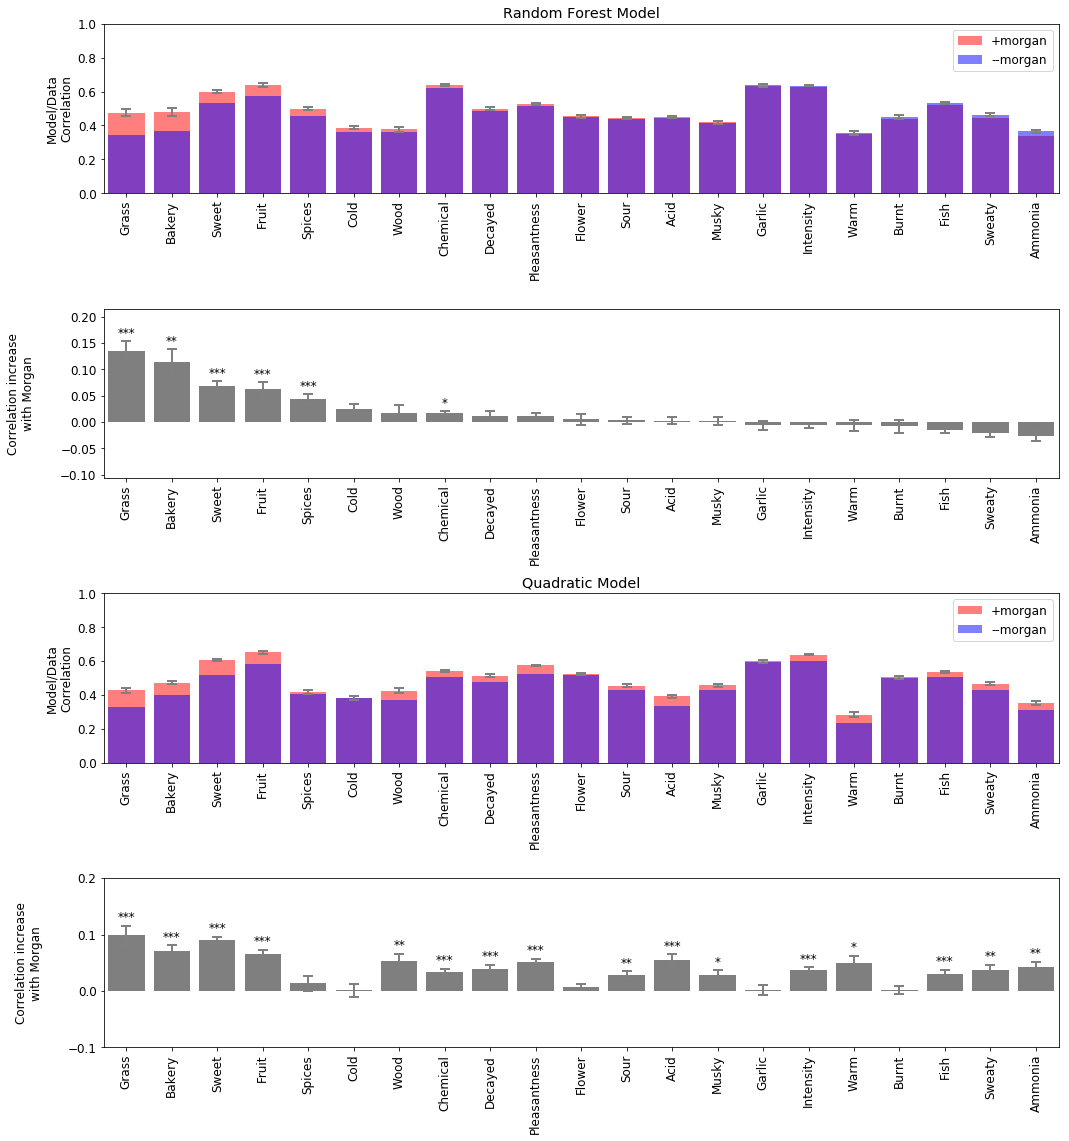

In [67]:
# Plot the correlations, with and without the Morgan features.  
mpl.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(4,1,figsize=(15,16),sharex=False)

for i in range(2):
    ax[2*i].bar(np.arange(21),wit[i].mean(axis=1),color='r',yerr=yerr1[i],
          error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2),alpha=0.5,label='+morgan')
    ax[2*i].bar(np.arange(21),wout[i].mean(axis=1),color='b',yerr=yerr2[i],
          error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2),alpha=0.5,label='--morgan')
    ax[2*i+1].bar(np.arange(21),
              diff[i],
              yerr=yerr[i],color='k',#width=0.4,
              error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2),
              alpha=0.5)
    for j in range(21):
        if ps[i][j] < 0.001:
            star = '***'
        elif ps[i][j] < 0.01:
            star = '**'
        elif ps[i][j] < 0.05:
            star = '*'
        else:
            star = ''
        ax[2*i+1].text(j,diff[i][j]+(-1 if diff[i][j]<0 else 1)*(yerr[i][j]+0.015),star,
                       size=12,horizontalalignment='center',verticalalignment='center')
    ax[2*i].legend(fontsize=12)
    ax[2*i].set_ylim(0,1)
    ax[2*i+1].set_ylim(diff[i].min()-0.08,diff[i].max()+0.08)
    ax[2*i].set_ylabel('Model/Data\nCorrelation')
    ax[2*i+1].set_ylabel('Correlation increase\nwith Morgan')
    ax[2*i+1].yaxis.labelpad = 25
    ax[2*1+1].set_yticks(np.arange(-0.1,0.3,0.1))

for i in range(4):
    ax[i].set_xlim(-0.5,20.5)
    ax[i].set_xticks(np.arange(21))
    ax[i].set_xticklabels([descriptors[j] for j in order[int(i/2)]],rotation=90)
ax[0].set_title('Random Forest Model')
ax[2].set_title('Quadratic Model')
plt.tight_layout()

plt.savefig('../../figures/with_without_morgan.eps',format='eps')